In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import os
import random 
import sys
import warnings
import sklearn
import statsmodels.api as sm
from scipy import stats
from scipy.stats import shapiro, normaltest
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer 
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.feature_selection import VarianceThreshold, SelectKBest, mutual_info_classif, RFECV
from sklearn import metrics
from sklearn.metrics import roc_auc_score, brier_score_loss, accuracy_score
from sklearn.calibration import calibration_curve, CalibratedClassifierCV, CalibrationDisplay
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from tableone import TableOne
from IPython.display import display


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import statsmodels.api as sm
from tableone import TableOne
from IPython.display import display

# Pandas configuration 
pd.set_option('display.max_rows', 100)

# To plot pretty figures 
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=10)
mpl.rc('ytick', labelsize=10)

### Create a folder and define the save_fig() function which is used through 
### this notebook to save the figures in hig-res ####

PROJECT_ROOT_DIR = r"C:\Users\aleks\OneDrive - Coventry University\Desktop\Project_Data"
CHAPTER_ID = "project_figures"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [2]:
print(sklearn.__version__)

1.6.1


==== Create a set of pre-selected features and target variable ====

In [3]:
features = [
"n_pdvage","n_sex_dv","n_ethn_dv","n_urban_dv",
"n_hiqual_dv","n_fimnnet_dv","n_employ","n_marstat_dv",
"n_hhsize","n_rach16_dv","n_aidhh","n_scfrendany",
"n_screlany", "n_health","n_scsf1","n_scsf2a","n_scsf2b","n_scsf3a",
"n_scsf3b","n_scsf5", "n_browse","n_email","n_smlook", "n_scgentrust","n_scleftout","n_sclackcom",
"n_scisolate","n_smpost", "n_onlinebuy","n_onlinebank","n_gaming", "n_streaming",
"n_streammusic","n_smoker","n_finnow","n_finfut","n_scghq2_dv"
]

In [4]:
print(len(features)) 

37


=== Informative labels for features ===

In [5]:
column_mapping={
    'n_pdvage': 'dem_age', 
    'n_sex_dv':'dem_sex', 
    'n_ethn_dv': 'dem_ethnicity',
    'n_urban_dv': 'dem_urban_rural', 
    'n_hiqual_dv': 'dem_education_level',
    'n_fimnnet_dv': 'dem_income', 
    'n_employ': 'dem_emp_status', 
    'n_marstat_dv': 'dem_marital_status', 
    'n_hhsize': 'household_size', 
    'n_rach16_dv': 'responsible_for_child', 
    'n_aidhh': 'provides_care',
    'n_scfrendany':	'social_has_friends',  
    'n_screlany':	'social_has_family',
    'n_scgentrust':	'social_general_trust',
    'n_scleftout': 	'social_feels_left_out',
    'n_sclackcom':	'social_lacks_companionship',
    'n_scisolate': 'social_feels_isolated',
    'n_health':	'has_longterm_illness',
    'n_scsf1':	'general_health_rating',
    'n_scsf2a':	'health_limits_moderate_activity',
    'n_scsf2b':	'health_limits_stairs',
    'n_scsf3a':	'health_limits_daily_activities_amount',
    'n_scsf3b':	'health_limits_work_type',
    'n_scsf5':	'health_pain_interferse_activity_type',
    'n_browse':	'internet_browse_freq',
    'n_email':  'internet_email_freq',
    'n_smlook':	'internet_social_media_view_freq',
    'n_smpost':	'internet_social_media_post_freq',
    'n_onlinebuy':'internet_shopping_freq',
    'n_onlinebank':'internet_banking_freq',
    'n_gaming':	'internet_gaming_freq',
    'n_streaming': 	'internet_video_streaming_freq',
    'n_streammusic':'internet_music_streaming_freq',
    'n_smoker': 	'is_smoker',
    'n_finnow':	'financial_situation_current',
    'n_finfut':	'financial_situation_future',
    'n_scghq2_dv': 'ghq_binary',
}

In [6]:
df = pd.io.stata.read_stata(r"C:\Users\aleks\OneDrive - Coventry University\Desktop\Project_Data\UKDA-6614-stata\stata\stata13_se\ukhls\n_indresp.dta",
                    convert_categoricals=False,
                            columns=features
                    )

In [7]:
### Rename columns for clarity ###
df_new = df.rename(columns=column_mapping)

In [8]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35471 entries, 0 to 35470
Data columns (total 37 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   dem_age                                35471 non-null  int16  
 1   dem_sex                                35471 non-null  int8   
 2   dem_ethnicity                          35471 non-null  int8   
 3   dem_urban_rural                        35471 non-null  int8   
 4   dem_education_level                    35471 non-null  int8   
 5   dem_income                             35471 non-null  float32
 6   dem_emp_status                         35471 non-null  int8   
 7   dem_marital_status                     35471 non-null  int8   
 8   household_size                         35471 non-null  int8   
 9   responsible_for_child                  35471 non-null  int8   
 10  provides_care                          35471 non-null  int8   
 11  so

=== Missing values handling ===

Recode the below values into NaN and then remove all NaN values using listwise deletion.
(1) -1  "Don't know" 
(2) -2  "Refused"
(3) -7  "Proxy"
(4) -8  "Valid skip"
(5) -9  "Missing by error or implausible"

In [9]:
# Replace missing codes with NaN
missing_codes = [-1, -2, -7, -8, -9]
df_new = df_new.replace(missing_codes, np.nan)

In [10]:
# Check missing data before cleaning
print("Before cleaning:")
print(df_new.isnull().sum().sort_values(ascending=False))

Before cleaning:
provides_care                            6472
internet_music_streaming_freq            1872
internet_video_streaming_freq            1870
internet_banking_freq                    1865
internet_social_media_post_freq          1861
internet_gaming_freq                     1856
internet_shopping_freq                   1854
internet_social_media_view_freq          1853
internet_email_freq                      1850
internet_browse_freq                     1833
ghq_binary                               1357
social_has_family                        1201
social_general_trust                     1110
social_lacks_companionship               1105
social_has_friends                       1101
social_feels_left_out                    1098
social_feels_isolated                    1093
dem_education_level                      1073
health_limits_work_type                  1069
health_limits_daily_activities_amount    1024
health_pain_interferse_activity_type     1021
health_limits_sta

In [11]:
# Drop # 
df_clean = df_new.dropna().copy()

In [12]:
# Check #
print("After cleaning:")
print(df_clean.isnull().sum().sort_values(ascending=False))

After cleaning:
dem_age                                  0
dem_sex                                  0
dem_ethnicity                            0
dem_urban_rural                          0
dem_education_level                      0
dem_income                               0
dem_emp_status                           0
dem_marital_status                       0
household_size                           0
responsible_for_child                    0
provides_care                            0
social_has_friends                       0
social_has_family                        0
has_longterm_illness                     0
general_health_rating                    0
health_limits_moderate_activity          0
health_limits_stairs                     0
health_limits_daily_activities_amount    0
health_limits_work_type                  0
health_pain_interferse_activity_type     0
internet_browse_freq                     0
internet_email_freq                      0
internet_social_media_view_freq       

In [13]:
print(f"Before cleaning: {df_new.shape[0]} rows, {df_new.shape[1]} columns")
print(f"After cleaning: {df_clean.shape[0]} wierszy, {df_clean.shape[1]} columns")

Before cleaning: 35471 rows, 37 columns
After cleaning: 25514 wierszy, 37 columns


In [14]:
# Calculate how many rows were removed 
removed_rows = df_new.shape[0] - df_clean.shape[0]
remaining_rows = df_clean.shape[0]

print(f"\Removed: {removed_rows}")
print(f"Remaining: {remaining_rows}")

\Removed: 9957
Remaining: 25514


In [15]:
print(f"\Removed: {removed_rows}")
print(f"Remaining: {remaining_rows}")

\Removed: 9957
Remaining: 25514


In [16]:
# Calcuate % 
percent_removed = (removed_rows / df_new.shape[0]) * 100
percent_remaining = (remaining_rows / df_new.shape[0]) * 100

In [17]:
print(f"\n% Removed: {percent_removed:.2f}%")
print(f"% Remaining: {percent_remaining:.2f}%")


% Removed: 28.07%
% Remaining: 71.93%


In [18]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25514 entries, 0 to 35470
Data columns (total 37 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   dem_age                                25514 non-null  float64
 1   dem_sex                                25514 non-null  float64
 2   dem_ethnicity                          25514 non-null  float64
 3   dem_urban_rural                        25514 non-null  float64
 4   dem_education_level                    25514 non-null  float64
 5   dem_income                             25514 non-null  float32
 6   dem_emp_status                         25514 non-null  float64
 7   dem_marital_status                     25514 non-null  float64
 8   household_size                         25514 non-null  int8   
 9   responsible_for_child                  25514 non-null  int8   
 10  provides_care                          25514 non-null  float64
 11  social_

In [19]:
df_clean.shape

(25514, 37)

In [20]:
df_clean.head(10)

,dem_age,dem_sex,dem_ethnicity,dem_urban_rural,dem_education_level,dem_income,dem_emp_status,dem_marital_status,household_size,responsible_for_child,...,internet_social_media_post_freq,internet_shopping_freq,internet_banking_freq,internet_gaming_freq,internet_video_streaming_freq,internet_music_streaming_freq,is_smoker,financial_situation_current,financial_situation_future,ghq_binary
0,37.0,2.0,1.0,1.0,1.0,1857.079956,1.0,1.0,4,1,...,1.0,2.0,1.0,2.0,3.0,2.0,2.0,2.0,3.0,7.0
1,45.0,2.0,1.0,1.0,1.0,2378.750000,1.0,4.0,3,1,...,6.0,2.0,2.0,6.0,2.0,3.0,2.0,5.0,3.0,11.0
2,39.0,2.0,1.0,1.0,3.0,3206.000000,1.0,1.0,4,1,...,6.0,2.0,2.0,5.0,6.0,2.0,2.0,3.0,1.0,0.0
3,43.0,2.0,1.0,2.0,4.0,94.470001,2.0,1.0,4,1,...,5.0,3.0,2.0,3.0,6.0,2.0,2.0,3.0,3.0,5.0
4,32.0,2.0,1.0,1.0,5.0,2056.080078,1.0,6.0,3,1,...,3.0,3.0,2.0,1.0,2.0,2.0,2.0,2.0,3.0,4.0
5,35.0,2.0,1.0,1.0,1.0,2839.649902,1.0,1.0,3,1,...,3.0,1.0,1.0,3.0,1.0,3.0,2.0,1.0,3.0,0.0
6,37.0,1.0,1.0,1.0,9.0,838.500000,2.0,6.0,3,2,...,4.0,6.0,3.0,2.0,1.0,3.0,1.0,4.0,2.0,12.0
10,38.0,1.0,1.0,2.0,4.0,1156.239990,1.0,6.0,2,2,...,2.0,2.0,2.0,5.0,2.0,3.0,1.0,2.0,3.0,1.0
11,68.0,2.0,1.0,1.0,1.0,910.000000,2.0,6.0,2,2,...,6.0,5.0,6.0,5.0,6.0,6.0,2.0,2.0,3.0,0.0
12,77.0,1.0,1.0,1.0,2.0,1395.329956,2.0,3.0,2,2,...,6.0,6.0,5.0,6.0,6.0,6.0,2.0,4.0,2.0,8.0


In [21]:
### Create a copy so df_new won't be affected ###
df_clean = df_new.dropna().copy()

In [22]:
# Before mapping, check what values exist
print("Original dem_sex values before mapping:")
print(df_clean['dem_sex'].value_counts(dropna=False))

Original dem_sex values before mapping:
dem_sex
2.0    14055
1.0    11457
0.0        2
Name: count, dtype: int64


In [23]:
### Remove inconsistence ###
df_clean = df_clean[df_clean['dem_sex'] != 0]

In [24]:
#### Columns mapping #### 

In [25]:
#### Mapping ####

binary_direct_map = {
    1: "Yes", 
    2: "No",
} 
binary_direct_categories_ordered = [
    'No', 
    'Yes',
] 

dem_sex_map = {
    1: 'Male',
    2: 'Female',
}

dem_sex_categories_ordered = [
    'Female', 
    'Male',
] 

urban_rural_map = {
    1: 'Urban area',
    2: 'Rural area',

}

urban_rural_categories = [
    'Rural area', 
    'Urban area',
]


In [26]:
# List of binary columns originally coded as 1=Yes, 2 =No #
cols_to_map_yes_no = [
    'responsible_for_child',
    'provides_care',
    'has_longterm_illness',
    'is_smoker',
    'social_has_friends',
    'social_has_family'
]

In [27]:
# then convert to an unordered categorical type for cleaner representation and analysis
for col in cols_to_map_yes_no:
    df_clean[col] = df_clean[col].map(binary_direct_map)
    df_clean[col] = pd.Categorical(df_clean[col], 
                                   categories=binary_direct_categories_ordered, 
                                   ordered=False)

In [28]:
# Map numerical codes in 'dem_sex' to gender labels and convert to categorical 
df_clean['dem_sex'] = df_clean['dem_sex'].map(dem_sex_map)
df_clean['dem_sex'] = pd.Categorical(df_clean['dem_sex'], categories=dem_sex_categories_ordered, ordered=False)

In [29]:
# Map codes in 'dem_urban_rural' to area type labels and convert to categorical
df_clean['dem_urban_rural'] = df_clean['dem_urban_rural'].map(urban_rural_map)
df_clean['dem_urban_rural'] = pd.Categorical(df_clean['dem_urban_rural'], categories=urban_rural_categories, ordered=False)

In [30]:
def map_marital_status(x):
    if x in {3,4,5,6}:
        return 0
    elif x in {1,2}:
        return 1

def map_education_level(x):
    if x == 9:
        return 1
    elif x in {5,4,3}:
        return 2
    elif x in {1,2}:
        return 3
        
def map_household_status(x):
    if x in {1,2}:
        return 1
    elif x in {3,4}:
        return 2
    elif x in {5,6,7,8,9}:
        return 3

In [31]:
# Mapping for variables after custom binning #

marital_status_final_map = {
    0: 'Not in relationship',
    1: 'In relationship'
}

marital_status_categories = [
    'Not in relationship', 
    'In relationship'] # Order for nominal

education_level_final_map = {
    1: 'No formal education',
    2: 'Secondary/Other',
    3: 'Higher education',
}
# Define the logical order for this ordinal variable
education_level_categories_ordered = [
    'No formal education', 
    'Secondary/Other',
    'Higher education'
]

emp_status_final_map = {
    2: 'Unemployed/Retired/Other', 
    1: 'Employed'
}
emp_status_categories = ['Unemployed/Retired/Other', 
                         'Employed'] 

household_size_final_map = {
    1: '1-2 people',
    2: '3-4 people',
    3: '5+ people' 
}
# Define the logical order for this ordinal variable
household_size_categories_ordered = [
    '1-2 people', 
    '3-4 people', 
    '5+ people']

In [32]:
# --- Processing dem_marital_status ---
df_clean['dem_marital_status'] = df_clean['dem_marital_status'].apply(map_marital_status) # Runs your binning function
df_clean['dem_marital_status'] = df_clean['dem_marital_status'].map(marital_status_final_map) # Maps binned numbers to text
df_clean['dem_marital_status'] = pd.Categorical(df_clean['dem_marital_status'], categories=marital_status_categories, ordered=False) # Sets as Categorical

# --- Processing dem_education_level ---
df_clean['dem_education_level'] = df_clean['dem_education_level'].apply(map_education_level)
df_clean['dem_education_level'] = df_clean['dem_education_level'].map(education_level_final_map)
df_clean['dem_education_level'] = pd.Categorical(df_clean['dem_education_level'], categories=education_level_categories_ordered, ordered=True)

# --- Processing dem_emp_status ---
df_clean['dem_emp_status'] = df_clean['dem_emp_status'].map(emp_status_final_map)
df_clean['dem_emp_status'] = pd.Categorical(df_clean['dem_emp_status'], categories=emp_status_categories, ordered=False)

# --- Processing household_size ---
df_clean['household_size'] = df_clean['household_size'].apply(map_household_status)
df_clean['household_size'] = df_clean['household_size'].map(household_size_final_map)
df_clean['household_size'] = pd.Categorical(df_clean['household_size'], categories=household_size_categories_ordered, ordered=True)

In [33]:
# Verify the changes
display(df_clean[['dem_marital_status', 'dem_education_level', 'dem_emp_status', 'household_size']].value_counts())

dem_marital_status   dem_education_level  dem_emp_status            household_size
In relationship      Higher education     Employed                  3-4 people        3758
                     Secondary/Other      Employed                  3-4 people        2641
                                          Unemployed/Retired/Other  1-2 people        2528
                     Higher education     Employed                  1-2 people        2399
                                          Unemployed/Retired/Other  1-2 people        2290
                     Secondary/Other      Employed                  1-2 people        1736
Not in relationship  Secondary/Other      Employed                  3-4 people        1023
                                          Unemployed/Retired/Other  3-4 people         925
                     Higher education     Employed                  3-4 people         850
In relationship      Secondary/Other      Unemployed/Retired/Other  3-4 people         788
       

In [34]:
# Map ethinicity # 
def map_ethnicity(x):
    """
    Maps a numerical ethnicity code to a grouped ethnicity label.

    Parameters:
        x (int): A numeric code representing ethnicity.

    Returns:
        str: One of the grouped labels: 'White', 'Mixed', 'Asian', 'Black', or 'Other'.
    """
    
    if x in [1, 2, 3, 4]:
        return 'White'
    elif x in [5, 6, 7, 8]:
        return 'Mixed'
    elif x in [9, 10, 11, 12, 13]:
        return 'Asian'
    elif x in [14, 15, 16]:
        return 'Black'
    elif x in [17, 97]:
        return 'Other'

ethnicity_categories = [
    'White',
    'Mixed',
    'Asian',
    'Black',
    'Other'
   
]

df_clean.loc[:, 'dem_ethnicity'] = df_clean['dem_ethnicity'].apply(map_ethnicity)

In [35]:
### Convert to categorical ###
df_clean.loc[:, 'dem_ethnicity'] = pd.Categorical(df_clean['dem_ethnicity'],
                                                   categories=ethnicity_categories,
                                                   ordered=False) 

In [36]:
# Check #
display(df_clean['dem_ethnicity'].value_counts(dropna=False))

dem_ethnicity
White    21981
Asian     2342
Black      597
Mixed      500
Other       92
Name: count, dtype: int64

In [37]:
print(df_clean.shape)

(25512, 37)


In [38]:
# dictionary and order (from most frequent to least frequent)
# Map columns 
ucla_score_map = {
    1: 1,  # "Hardly ever or never" = 1 score 
    2: 2,  # "Some of the time" = 2 score  
    3: 3   # "Often" = 3 scores 
}

#  UCLA loneliness scale columns 
ucla_loneliness_cols = [
    'social_feels_left_out',      # n_scleftout
    'social_lacks_companionship', # n_sclackcom
    'social_feels_isolated'       # n_scisolate
]

# Calculate composite score #
df_clean['UCLA_loneliness_score'] = df_clean[ucla_loneliness_cols].sum(axis=1)

# drop initial columns
df_clean = df_clean.drop(columns=ucla_loneliness_cols)

In [39]:
print(df_clean['UCLA_loneliness_score'].value_counts().sort_index())

UCLA_loneliness_score
3.0    12798
4.0     3149
5.0     2723
6.0     4580
7.0      963
8.0      550
9.0      749
Name: count, dtype: int64


In [40]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25512 entries, 0 to 35470
Data columns (total 35 columns):
 #   Column                                 Non-Null Count  Dtype   
---  ------                                 --------------  -----   
 0   dem_age                                25512 non-null  float64 
 1   dem_sex                                25512 non-null  category
 2   dem_ethnicity                          25512 non-null  object  
 3   dem_urban_rural                        25512 non-null  category
 4   dem_education_level                    25512 non-null  category
 5   dem_income                             25512 non-null  float32 
 6   dem_emp_status                         25512 non-null  category
 7   dem_marital_status                     25512 non-null  category
 8   household_size                         25512 non-null  category
 9   responsible_for_child                  25512 non-null  category
 10  provides_care                          25512 non-null  category

In [41]:


# dictionary and oreder (from 
internet_freq_map = {
    1: "Every day",
    2: "Several times a week",
    3: "Several times a month",
    4: "Once a month",
    5: "Less than once a month",
    6: "Never",
}
internet_freq_categories_ordered = [
    "Every day",
    "Several times a week",
    "Several times a month",
    "Once a month",
    "Less than once a month",
    "Never",
]

internet_freq_cols = [
    "internet_browse_freq",
    "internet_email_freq",
    "internet_social_media_view_freq",
    "internet_social_media_post_freq",
    "internet_shopping_freq",
    "internet_banking_freq",
    "internet_gaming_freq",
    "internet_video_streaming_freq",
    "internet_music_streaming_freq",
]

def set_internet_freq_ordered(df, cols):
    """
    Converts internet frequency columns to ordered categorical variables.
    Maps numeric codes (1-6) to frequency labels and sets proper ordering.
    
    """
    for col in cols:
        s = df[col]
        
        # If already target labels, just set as categorical
        if s.dropna().isin(internet_freq_categories_ordered).all():
            df[col] = pd.Categorical(s, categories=internet_freq_categories_ordered, ordered=True)
            continue
            
        # Try to map 1..6 -> labels
        sn = pd.to_numeric(s, errors="coerce")
        mapped = sn.map(internet_freq_map)
        df[col] = pd.Categorical(mapped, categories=internet_freq_categories_ordered, ordered=True)
    
    return df

In [42]:
df_clean = set_internet_freq_ordered(df_clean, internet_freq_cols)

In [43]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25512 entries, 0 to 35470
Data columns (total 35 columns):
 #   Column                                 Non-Null Count  Dtype   
---  ------                                 --------------  -----   
 0   dem_age                                25512 non-null  float64 
 1   dem_sex                                25512 non-null  category
 2   dem_ethnicity                          25512 non-null  object  
 3   dem_urban_rural                        25512 non-null  category
 4   dem_education_level                    25512 non-null  category
 5   dem_income                             25512 non-null  float32 
 6   dem_emp_status                         25512 non-null  category
 7   dem_marital_status                     25512 non-null  category
 8   household_size                         25512 non-null  category
 9   responsible_for_child                  25512 non-null  category
 10  provides_care                          25512 non-null  category

In [44]:
def set_financial_current_ordered(df, col="financial_situation_current"):
    
    ordered_levels = [
        "Living comfortably",
        "Doing alright",
        "Just about getting by",
        "Finding it quite difficult",
        "Finding it very difficult",
    ]

    label_map = {
        1: "Living comfortably",
        2: "Doing alright",
        3: "Just about getting by",
        4: "Finding it quite difficult",
        5: "Finding it very difficult",
    }

    # Przekształć dane numeryczne (1..5) na etykiety słowne
    s = pd.to_numeric(df[col], errors="coerce")

    if s.notna().sum() > 0:
        # dane to liczby — przemapuj
        labels = s.map(label_map)
    else:
        # dane to tekst — użyj ich bez zmian
        labels = df[col].astype("string").str.strip()

    # Ustaw uporządkowaną kategorię
    df[col] = pd.Categorical(labels, categories=ordered_levels, ordered=True)

    # Dodaj kody 0..4 (a -1 to brak danych)
    df[col + "_code"] = df[col].cat.codes

    return df


In [45]:
df_clean = set_financial_current_ordered(df_clean, col="financial_situation_current")

In [46]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25512 entries, 0 to 35470
Data columns (total 36 columns):
 #   Column                                 Non-Null Count  Dtype   
---  ------                                 --------------  -----   
 0   dem_age                                25512 non-null  float64 
 1   dem_sex                                25512 non-null  category
 2   dem_ethnicity                          25512 non-null  object  
 3   dem_urban_rural                        25512 non-null  category
 4   dem_education_level                    25512 non-null  category
 5   dem_income                             25512 non-null  float32 
 6   dem_emp_status                         25512 non-null  category
 7   dem_marital_status                     25512 non-null  category
 8   household_size                         25512 non-null  category
 9   responsible_for_child                  25512 non-null  category
 10  provides_care                          25512 non-null  category

In [47]:
print(df_clean["financial_situation_current"].head())
print(df_clean["financial_situation_current"].dtype)
print(df_clean["financial_situation_current"].cat.categories)
print(df_clean["financial_situation_current"].value_counts(dropna=False))
print(df_clean["financial_situation_current"].cat.codes.unique())

0                Doing alright
1    Finding it very difficult
2        Just about getting by
3        Just about getting by
4                Doing alright
Name: financial_situation_current, dtype: category
Categories (5, object): ['Living comfortably' < 'Doing alright' < 'Just about getting by' < 'Finding it quite difficult' < 'Finding it very difficult']
category
Index(['Living comfortably', 'Doing alright', 'Just about getting by',
       'Finding it quite difficult', 'Finding it very difficult'],
      dtype='object')
financial_situation_current
Doing alright                 11054
Living comfortably             6686
Just about getting by          5509
Finding it quite difficult     1702
Finding it very difficult       561
Name: count, dtype: int64
[1 4 2 0 3]


In [48]:
df_clean = set_financial_current_ordered(df_clean)

In [49]:
def set_financial_future_ordered(df, col="financial_situation_future"):
    
    s = pd.to_numeric(df[col], errors="coerce")

    
    label_map = {
        1: "Better off",
        2: "Worse off than now",
        3: "About the same",
    }
    
    ordered_levels = [
        "Better off",
        "About the same",
        "Worse off than now",
    ]

    df[col] = pd.Categorical(s.map(label_map), categories=ordered_levels, ordered=True)
    return df

In [50]:
df_clean = set_financial_future_ordered(df_clean, col="financial_situation_future")

In [51]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25512 entries, 0 to 35470
Data columns (total 36 columns):
 #   Column                                 Non-Null Count  Dtype   
---  ------                                 --------------  -----   
 0   dem_age                                25512 non-null  float64 
 1   dem_sex                                25512 non-null  category
 2   dem_ethnicity                          25512 non-null  object  
 3   dem_urban_rural                        25512 non-null  category
 4   dem_education_level                    25512 non-null  category
 5   dem_income                             25512 non-null  float32 
 6   dem_emp_status                         25512 non-null  category
 7   dem_marital_status                     25512 non-null  category
 8   household_size                         25512 non-null  category
 9   responsible_for_child                  25512 non-null  category
 10  provides_care                          25512 non-null  category

In [52]:
def set_general_health_ordered(df, col='general_health_rating'):
    
    s = pd.to_numeric(df[col], errors="coerce")

    label_map = {
        1: "Excellent",
        2: "Very Good",
        3: "Good",
        4: "Fair",
        5: "Poor"
    }

    ordered_levels = [
        "Excellent",
        "Very Good",
        "Good",
        "Fair",
        "Poor"
    ]

    df[col] = pd.Categorical(s.map(label_map), categories=ordered_levels, ordered=True)
    return df

In [53]:
df_clean = set_general_health_ordered(df_clean, col="general_health_rating")

In [54]:
df_clean['general_health_rating'].value_counts()

general_health_rating
Good         9126
Very Good    8377
Fair         4245
Excellent    2449
Poor         1315
Name: count, dtype: int64

In [55]:
health_limits_cols = [
    "health_limits_daily_activities_amount",
    "health_limits_work_type",
]

def set_role_physical_limits(df, cols):
    label_map = {
        1: "All of the time",
        2: "Most of the time",
        3: "Some of the time",
        4: "A little of the time",
        5: "None of the time",
    }
    # Porządek od najlepszego do najgorszego (ułatwia kody 0..4)
    ordered_levels = [
        "None of the time",
        "A little of the time",
        "Some of the time",
        "Most of the time",
        "All of the time",
    ]
    for col in cols:
        s = pd.to_numeric(df[col], errors="coerce")
        df[col] = pd.Categorical(s.map(label_map), categories=ordered_levels, ordered=True)
    return df

In [56]:
df_clean = set_role_physical_limits(df_clean, health_limits_cols)

In [57]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25512 entries, 0 to 35470
Data columns (total 36 columns):
 #   Column                                 Non-Null Count  Dtype   
---  ------                                 --------------  -----   
 0   dem_age                                25512 non-null  float64 
 1   dem_sex                                25512 non-null  category
 2   dem_ethnicity                          25512 non-null  object  
 3   dem_urban_rural                        25512 non-null  category
 4   dem_education_level                    25512 non-null  category
 5   dem_income                             25512 non-null  float32 
 6   dem_emp_status                         25512 non-null  category
 7   dem_marital_status                     25512 non-null  category
 8   household_size                         25512 non-null  category
 9   responsible_for_child                  25512 non-null  category
 10  provides_care                          25512 non-null  category

In [58]:
print(df_clean.shape)

(25512, 36)


In [59]:
def set_pain_interference(df_clean, col="health_pain_interferse_activity_type"):
    s = pd.to_numeric(df_clean[col], errors="coerce")

    label_map = {
        1: "All of the time",
        2: "Most of the time",
        3: "Some of the time",
        4: "A little of the time",
        5: "None of the time",
    }

    ordered_levels = [
        "None of the time",
        "A little of the time",
        "Some of the time",
        "Most of the time",
        "All of the time",
    ]  

    df_clean[col] = pd.Categorical(s.map(label_map), categories=ordered_levels, ordered=True)
    return df_clean

In [60]:
df_clean = set_pain_interference(df_clean, col='health_pain_interferse_activity_type')

In [61]:

health_limits_specific_cols = [
    "health_limits_moderate_activity",
    "health_limits_stairs",
]

def set_health_limits_ordered(df, cols):
    
    ordered_levels = [
        "No, not limited at all",
        "Yes, limited a little",
        "Yes, limited a lot",
    ]
    label_map = {
        1: "Yes, limited a lot",
        2: "Yes, limited a little",
        3: "No, not limited at all",
    }
    for col in cols:
        
        s = pd.to_numeric(df[col], errors="coerce")
        
        df[col] = pd.Categorical(s.map(label_map), categories=ordered_levels, ordered=True)
    return df

In [62]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25512 entries, 0 to 35470
Data columns (total 36 columns):
 #   Column                                 Non-Null Count  Dtype   
---  ------                                 --------------  -----   
 0   dem_age                                25512 non-null  float64 
 1   dem_sex                                25512 non-null  category
 2   dem_ethnicity                          25512 non-null  object  
 3   dem_urban_rural                        25512 non-null  category
 4   dem_education_level                    25512 non-null  category
 5   dem_income                             25512 non-null  float32 
 6   dem_emp_status                         25512 non-null  category
 7   dem_marital_status                     25512 non-null  category
 8   household_size                         25512 non-null  category
 9   responsible_for_child                  25512 non-null  category
 10  provides_care                          25512 non-null  category

In [63]:
# Double check for missing values. 
total = df_clean.isnull().sum().sort_values(ascending=False)
percent = (df_clean.isnull().sum()/df_clean.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
dem_age,0,0.0
dem_sex,0,0.0
dem_ethnicity,0,0.0
dem_urban_rural,0,0.0
dem_education_level,0,0.0
dem_income,0,0.0
dem_emp_status,0,0.0
dem_marital_status,0,0.0
household_size,0,0.0
responsible_for_child,0,0.0


In [64]:
print(df_clean.shape)

(25512, 36)


In [65]:
df_clean['dem_income'].min()

np.float32(-3333.33)

==== Psychological distress outcome variable: GHQ-12 binary transformation and class imbalance ====

==== Target variable creation ====

In [66]:
# Convert to binary
GHQ_THRESHOLD = 4
df_clean['ghq_binary'] = (df_clean['ghq_binary'] >= GHQ_THRESHOLD).astype(int)

class_counts = df_clean['ghq_binary'].value_counts()
total_samples = class_counts.sum()
class_counts_percentage = (class_counts / total_samples) * 100

In [67]:
print(f"Number of classes:{class_counts}")
print(f"Number of samples: {total_samples}")
print(f"Percentage: {class_counts_percentage}")

Number of classes:ghq_binary
0    20257
1     5255
Name: count, dtype: int64
Number of samples: 25512
Percentage: ghq_binary
0    79.40185
1    20.59815
Name: count, dtype: float64


Saving figure imbalanced-1.png


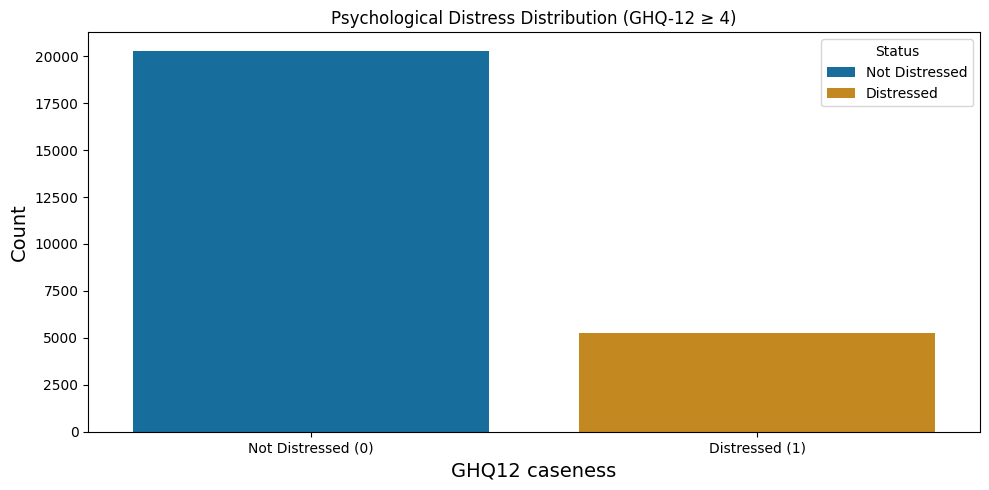

In [68]:
plt.figure(figsize=(10,5))
ax = sns.countplot(x=df_clean['ghq_binary'], 
              hue=df_clean['ghq_binary'], 
              palette='colorblind', 
              legend=True)
plt.xticks([0,1], labels=['Not Distressed (0)', 'Distressed (1)'])
ax.set_xlabel("GHQ12 caseness")
ax.set_ylabel("Count")
plt.title("Psychological Distress Distribution (GHQ-12 ≥ 4)")

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ['Not Distressed', 'Distressed'], title='Status')

plt.tight_layout()
save_fig("imbalanced-1.png")
plt.show()

Saving figure Distribution


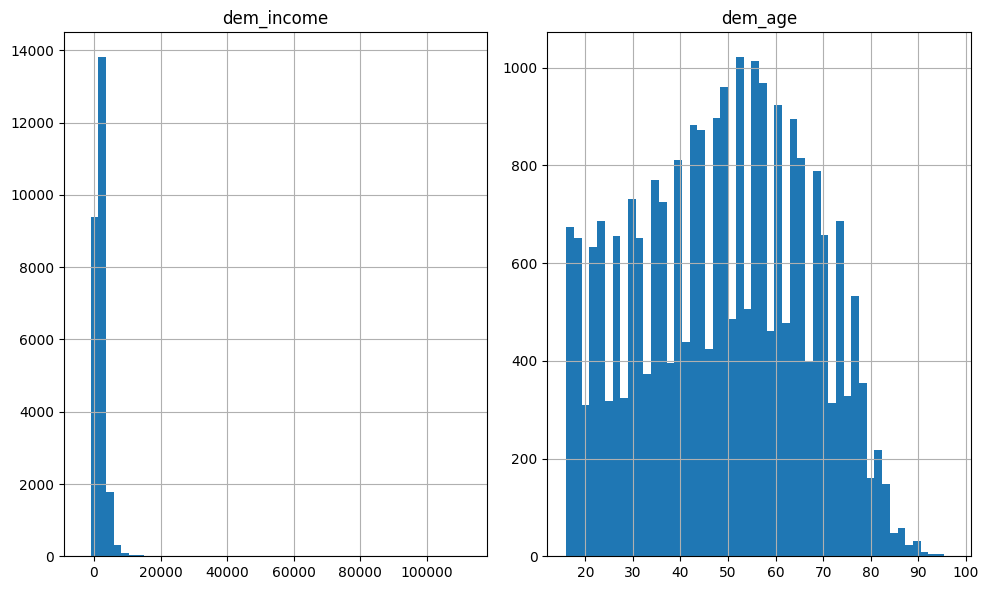

In [69]:
#### Income is known to be right skewed #### 
#### Hist confirms that the income is right-skewed ####
#### Ogon ciagnie sie w prawo (najbogatsi) ####
#### The logtransformation is used to reduce skewness of a
#### measurement variable. #####
#### Ekstremalnie skweded (18.655525) ####
#### Leave it as it is - RF, MLP, XGB and SVM do not assume normally 
#### distributed features #####

df_clean[['dem_income','dem_age']].hist(bins=50, figsize=(10,6))
save_fig('Distribution')
plt.show()

In [70]:
#### Check skewness of the data ####
df_clean[['dem_age', 'dem_income', 'UCLA_loneliness_score']].skew()

dem_age                  -0.038280
dem_income               18.201048
UCLA_loneliness_score     1.070291
dtype: float64

Saving figure QQ Plot


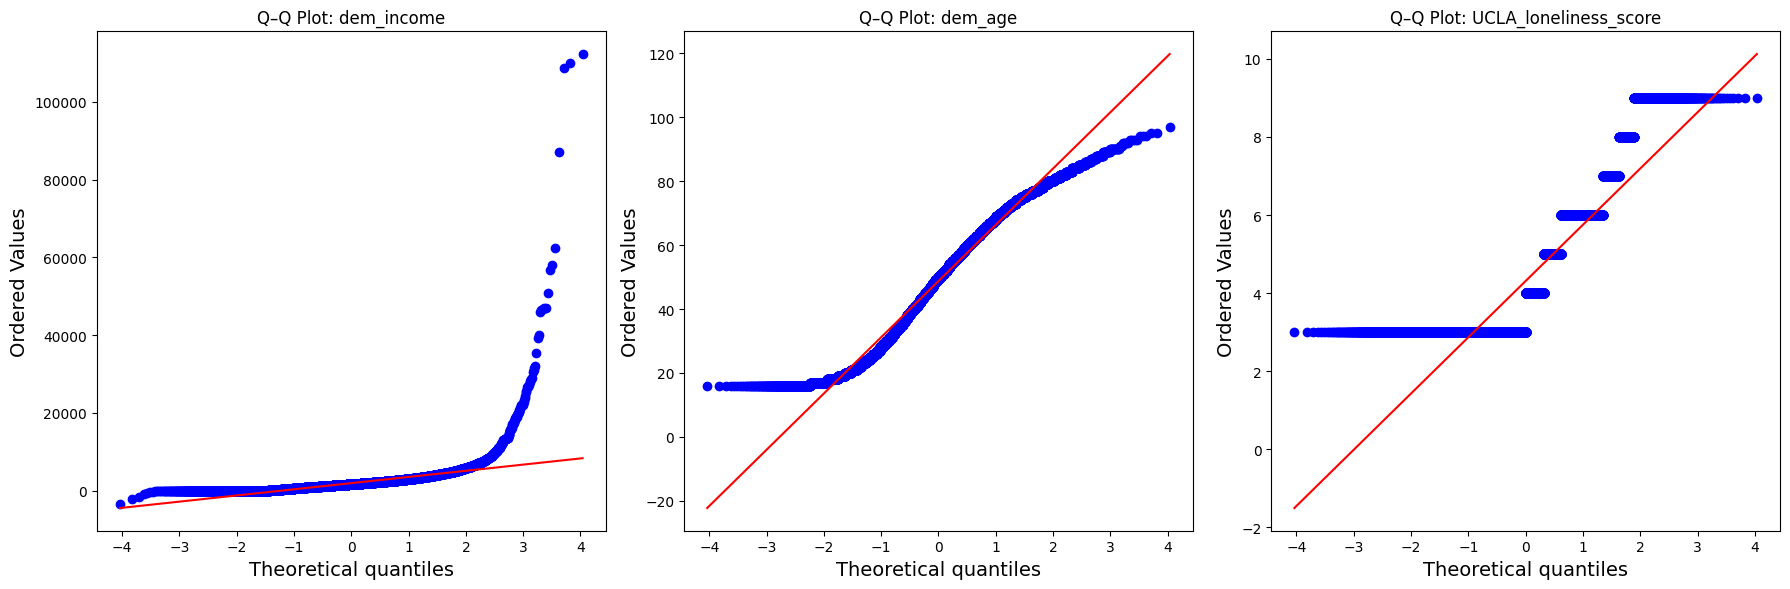

In [71]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Q-Q plot for dem_income
stats.probplot(df_clean['dem_income'], dist="norm", plot=axes[0])
axes[0].set_title("Q–Q Plot: dem_income")

# Q-Q plot for dem_age
stats.probplot(df_clean['dem_age'], dist="norm", plot=axes[1])
axes[1].set_title("Q–Q Plot: dem_age")

# Q-Q plot for dem_age
stats.probplot(df_clean['UCLA_loneliness_score'], dist="norm", plot=axes[2])
axes[2].set_title("Q–Q Plot: UCLA_loneliness_score")

plt.tight_layout()
save_fig("QQ Plot")
plt.show()

In [72]:
# Sprawdź założenia dokładniej:
from scipy.stats import shapiro, normaltest

# Test normalności
stat, p = shapiro(df_clean['dem_age'])
print(f"Shapiro-Wilk p-value: {p}")

# Jeśli p < 0.05, dane nie są normalne -> Mann-Whitney OK

Shapiro-Wilk p-value: 1.5909995633731263e-52


C:\Users\aleks\shap-env\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 25512.
  res = hypotest_fun_out(*samples, **kwds)


In [73]:
stat, p = shapiro(df_clean['dem_income'])
print(f"Shapiro-Wilk p-value: {p}")

Shapiro-Wilk p-value: 3.2884781136794844e-126


In [74]:
stat, p = shapiro(df_clean['UCLA_loneliness_score'])
print(f"Shapiro-Wilk p-value: {p}")

Shapiro-Wilk p-value: 8.951876597545705e-101


In [75]:
# Bazowane na rzeczywistych kategoriach ekonomicznych
def create_income_categories(income):
    if income <= 25000:
        return 'Low'
    elif income <= 50000:
        return 'Lower-Middle'
    elif income <= 100000:
        return 'Middle'
    else:
        return 'High'

df_clean['income_group'] = df_clean['dem_income'].apply(create_income_categories)

In [76]:
df_clean['income_group'].value_counts()

income_group
Low             25482
Lower-Middle       22
Middle              5
High                3
Name: count, dtype: int64

In [77]:
df_clean = df_clean.drop(['dem_income'], axis=1)

In [78]:
df_clean.columns.to_list()

['dem_age',
 'dem_sex',
 'dem_ethnicity',
 'dem_urban_rural',
 'dem_education_level',
 'dem_emp_status',
 'dem_marital_status',
 'household_size',
 'responsible_for_child',
 'provides_care',
 'social_has_friends',
 'social_has_family',
 'has_longterm_illness',
 'general_health_rating',
 'health_limits_moderate_activity',
 'health_limits_stairs',
 'health_limits_daily_activities_amount',
 'health_limits_work_type',
 'health_pain_interferse_activity_type',
 'internet_browse_freq',
 'internet_email_freq',
 'internet_social_media_view_freq',
 'social_general_trust',
 'internet_social_media_post_freq',
 'internet_shopping_freq',
 'internet_banking_freq',
 'internet_gaming_freq',
 'internet_video_streaming_freq',
 'internet_music_streaming_freq',
 'is_smoker',
 'financial_situation_current',
 'financial_situation_future',
 'ghq_binary',
 'UCLA_loneliness_score',
 'financial_situation_current_code',
 'income_group']

In [79]:
df_clean = df_clean.drop('financial_situation_current_code', axis=1)

In [80]:
# all features # 
columns = [
 'dem_age',
 'dem_sex',
 'dem_ethnicity',
 'dem_urban_rural',
 'dem_education_level',
 'dem_emp_status',
 'dem_marital_status',
 'household_size',
 'responsible_for_child',
 'provides_care',
 'social_has_friends',
 'social_has_family',
 'social_general_trust',
 'has_longterm_illness',
 'health_limits_moderate_activity',
 'health_limits_stairs',
 'health_limits_daily_activities_amount',
 'health_limits_work_type',
 'health_pain_interferse_activity_type',
 'internet_browse_freq',
 'internet_email_freq',
 'internet_social_media_view_freq',
 'internet_social_media_post_freq',
 'internet_shopping_freq',
 'internet_banking_freq',
 'internet_gaming_freq',
 'internet_video_streaming_freq',
 'internet_music_streaming_freq',
 'is_smoker',
 'financial_situation_current',
 'financial_situation_future',
 'ghq_binary',
 'UCLA_loneliness_score',
 'general_health_rating',
 'income_group']


#### categorical variables  #####
categorical = [
 'dem_sex',
 'dem_ethnicity',
 'dem_urban_rural',
 'dem_education_level',
 'dem_emp_status',
 'dem_marital_status',
 'household_size',
 'responsible_for_child',
 'provides_care',
 'social_has_friends',
 'social_has_family',
 'social_general_trust',
 'has_longterm_illness',
 'health_limits_moderate_activity',
 'health_limits_stairs',
 'health_limits_daily_activities_amount',
 'health_limits_work_type',
 'health_pain_interferse_activity_type',
 'internet_browse_freq',
 'internet_email_freq',
 'internet_social_media_view_freq',
 'internet_social_media_post_freq',
 'internet_shopping_freq',
 'internet_banking_freq',
 'internet_gaming_freq',
 'internet_video_streaming_freq',
 'internet_music_streaming_freq',
 'is_smoker',
 'financial_situation_current',
 'financial_situation_future',
 'ghq_binary',
 'general_health_rating',
 'income_group'
]

In [81]:
groupby = 'ghq_binary'

table1 = TableOne(data=df_clean, 
                  columns=columns, 
                  categorical=categorical,
                  groupby=groupby,
                  nonnormal=[
                      'dem_age',
                      'UCLA_loneliness_score', 
                      'social_general_trust'],  # Mann-Whitney test 
                  pval=True)

In [82]:
# Display in nice format i Jupyter # 
table1_df = table1.tableone
display(table1_df)
table1_df.to_csv(r"C:\Users\aleks\OneDrive - Coventry University\Desktop\Project_Data\table1_ghq_binary.csv")

Grouped by ghq_binary  \
                                                        Missing   
n                                                                 
dem_age, median [Q1,Q3]                                       0   
dem_sex, n (%)               Female                               
                             Male                                 
dem_ethnicity, n (%)         Asian                                
...                                                         ...   
general_health_rating, n (%) Poor                                 
income_group, n (%)          High                                 
                             Low                                  
                             Lower-Middle                         
                             Middle                               

                                                                               \
                                                    Overall                 0   
n                                                     25512             20257   
dem_age, median [Q1,Q3]                    50.0 [34.0,63.0]  51.0 [36.0,64.0]   
dem_sex, n (%)               Female            14055 (55.1)      10656 (52.6)   
                             Male              11457 (44.9)       9601 (47.4)   
dem_ethnicity, n (%)         Asian               2342 (9.2)        1866 (9.2)   
...                                                     ...               ...   
general_health_rating, n (%) Poor                1315 (5.2)         469 (2.3)   
income_group, n (%)          High                   3 (0.0)           3 (0.0)   
                             Low               25482 (99.9)      20232 (99.9)   
                             Lower-Middle          22 (0.1)          18 (0.1)   
                             Middle                 5 (0.0)           4 (0.0)   

                                                                     
                                                          1 P-Value  
n                                                      5255          
dem_age, median [Q1,Q3]                    45.0 [31.0,58.0]  <0.001  
dem_sex, n (%)               Female             3399 (64.7)  <0.001  
                             Male               1856 (35.3)          
dem_ethnicity, n (%)         Asian                476 (9.1)   0.016  
...                                                     ...     ...  
general_health_rating, n (%) Poor                846 (16.1)          
income_group, n (%)          High                   0 (0.0)   0.835  
                             Low                5250 (99.9)          
                             Lower-Middle           4 (0.1)          
                             Middle                 1 (0.0)          

[139 rows x 5 columns]

In [83]:
df_clean.shape

(25512, 35)

In [84]:
df_clean.head(10)

,dem_age,dem_sex,dem_ethnicity,dem_urban_rural,dem_education_level,dem_emp_status,dem_marital_status,household_size,responsible_for_child,provides_care,...,internet_banking_freq,internet_gaming_freq,internet_video_streaming_freq,internet_music_streaming_freq,is_smoker,financial_situation_current,financial_situation_future,ghq_binary,UCLA_loneliness_score,income_group
0,37.0,Female,White,Urban area,Higher education,Employed,In relationship,3-4 people,Yes,No,...,Every day,Several times a week,Several times a month,Several times a week,No,Doing alright,About the same,1,7.0,Low
1,45.0,Female,White,Urban area,Higher education,Employed,Not in relationship,3-4 people,Yes,No,...,Several times a week,Never,Several times a week,Several times a month,No,Finding it very difficult,About the same,1,6.0,Low
2,39.0,Female,White,Urban area,Secondary/Other,Employed,In relationship,3-4 people,Yes,No,...,Several times a week,Less than once a month,Never,Several times a week,No,Just about getting by,Better off,0,3.0,Low
3,43.0,Female,White,Rural area,Secondary/Other,Unemployed/Retired/Other,In relationship,3-4 people,Yes,No,...,Several times a week,Several times a month,Never,Several times a week,No,Just about getting by,About the same,1,5.0,Low
4,32.0,Female,White,Urban area,Secondary/Other,Employed,Not in relationship,3-4 people,Yes,No,...,Several times a week,Every day,Several times a week,Several times a week,No,Doing alright,About the same,1,4.0,Low
5,35.0,Female,White,Urban area,Higher education,Employed,In relationship,3-4 people,Yes,No,...,Every day,Several times a month,Every day,Several times a month,No,Living comfortably,About the same,0,3.0,Low
6,37.0,Male,White,Urban area,No formal education,Unemployed/Retired/Other,Not in relationship,3-4 people,No,Yes,...,Several times a month,Several times a week,Every day,Several times a month,Yes,Finding it quite difficult,Worse off than now,1,8.0,Low
10,38.0,Male,White,Rural area,Secondary/Other,Employed,Not in relationship,1-2 people,No,No,...,Several times a week,Less than once a month,Several times a week,Several times a month,Yes,Doing alright,About the same,0,3.0,Low
11,68.0,Female,White,Urban area,Higher education,Unemployed/Retired/Other,Not in relationship,1-2 people,No,No,...,Never,Less than once a month,Never,Never,No,Doing alright,About the same,0,5.0,Low
12,77.0,Male,White,Urban area,Higher education,Unemployed/Retired/Other,Not in relationship,1-2 people,No,No,...,Less than once a month,Never,Never,Never,No,Finding it quite difficult,Worse off than now,1,7.0,Low


In [85]:
X = df_clean.drop('ghq_binary', axis=1)
y = df_clean['ghq_binary']

In [86]:

# ========= 1) ORDINAL =========
internet_order = [
    "Every day",
    "Several times a week",
    "Several times a month",
    "Once a month",
    "Less than once a month",
    "Never",
]
fin_now_order = [
    "Living comfortably",
    "Doing alright",
    "Just about getting by",
    "Finding it quite difficult",
    "Finding it very difficult",
]
fin_fut_order = [
    "Better off",
    "About the same",
    "Worse off than now",
]
role_phys_order = [  # n_scsf3a / n_scsf3b
    "None of the time",
    "A little of the time",
    "Some of the time",
    "Most of the time",
    "All of the time",
]
limit_order = [  # n_scsf2a / n_scsf2b
    "No, not limited at all",
    "Yes, limited a little",
    "Yes, limited a lot",
]
pain_order = [  # n_scsf5
    "None of the time",
    "A little of the time",
    "Some of the time",
    "Most of the time",
    "All of the time",
]

general_health_order = [
        "Excellent",
        "Very Good",
        "Good",
        "Fair",
        "Poor"
    ]


# Ordinal columns 
ordinal_plan = {
    "financial_situation_current": fin_now_order,
    "financial_situation_future": fin_fut_order,
    "health_limits_daily_activities_amount": role_phys_order,
    "health_limits_work_type": role_phys_order,
    "health_limits_moderate_activity": limit_order,
    "health_limits_stairs": limit_order,
    "health_pain_interferse_activity_type": pain_order,
    "general_health_rating": general_health_order,

    "internet_browse_freq": internet_order,
    "internet_email_freq": internet_order,
    "internet_social_media_view_freq": internet_order,
    "internet_social_media_post_freq": internet_order,
    "internet_shopping_freq": internet_order,
    "internet_banking_freq": internet_order,
    "internet_gaming_freq": internet_order,
    "internet_video_streaming_freq": internet_order,
    "internet_music_streaming_freq": internet_order,
}

In [87]:
# Function: set as oredered categorical
def encode_ordered_to_codes(df, col, ordered_levels):
    if col not in df.columns:
        return
    s = df[col]
    
    sn = pd.to_numeric(s, errors="coerce")
    if sn.notna().any() and s.dropna().dtype != "category":
        
        mapping = {i+1: lvl for i, lvl in enumerate(ordered_levels)}
        s = sn.map(mapping)
    
    s_cat = pd.Categorical(s, categories=ordered_levels, ordered=True)
    
    df[col] = pd.Series(s_cat.codes, index=df.index).replace(-1, np.nan).astype("float32")

# Encode all ordinal variables 
ordinal_variables = []
for col, order_ in ordinal_plan.items():
    if col in X.columns:
        encode_ordered_to_codes(X, col, order_)
        ordinal_variables.append(col)

print(f"Ordinal variables: {ordinal_variables}")

Ordinal variables: ['financial_situation_current', 'financial_situation_future', 'health_limits_daily_activities_amount', 'health_limits_work_type', 'health_limits_moderate_activity', 'health_limits_stairs', 'health_pain_interferse_activity_type', 'general_health_rating', 'internet_browse_freq', 'internet_email_freq', 'internet_social_media_view_freq', 'internet_social_media_post_freq', 'internet_shopping_freq', 'internet_banking_freq', 'internet_gaming_freq', 'internet_video_streaming_freq', 'internet_music_streaming_freq']


In [88]:
# ========= 2) BINARNE =========
# Binary variables 
binary_variables = []
def add_bin(name):
    if name in X.columns and name not in ordinal_variables:
        binary_variables.append(name)

add_bin('dem_sex')               # 1=female, 0=male 
add_bin('dem_urban_rural')       # 1=urban, 0=rural
add_bin('dem_emp_status')        
add_bin('dem_marital_status')    
add_bin('responsible_for_child')
add_bin('provides_care')
add_bin('has_longterm_illness')
add_bin('is_smoker')
add_bin('social_has_friends')
add_bin('social_has_family')
# NIC z *_binary tu nie dodajemy

print(f"Binary variables (0/1): {binary_variables}")

# Maps binary 
for col in binary_variables:

    vals = X[col].astype(str)
    if col == 'dem_sex':
        # oryg. UKHLS Male=1, Female=2 -> in this project Female=1, Male=0
        X[col] = vals.map({'2': 1, '1': 0, 'female': 1, 'male': 0}).astype('Int64').fillna(0).astype(int)
    elif col in ['dem_urban_rural','dem_emp_status','dem_marital_status',
                 'responsible_for_child','provides_care','has_longterm_illness',
                 'social_has_friends','social_has_family','is_smoker']:
        # standard: Yes=1, No=2 -> 1;2 -> 1;0
        X[col] = vals.map({'1': 1, '2': 0, 'Yes': 1, 'No': 0}).astype('Int64').fillna(0).astype(int)

Binary variables (0/1): ['dem_sex', 'dem_urban_rural', 'dem_emp_status', 'dem_marital_status', 'responsible_for_child', 'provides_care', 'has_longterm_illness', 'is_smoker', 'social_has_friends', 'social_has_family']


In [89]:

# ========= 3) NOMINAL =========
nominal_variables = []
def add_nom(name):
    # add variable to nominal list 
    if name in X.columns and name not in ordinal_variables and name not in binary_variables:
        nominal_variables.append(name)

add_nom('dem_ethnicity')
add_nom('dem_education_level')
add_nom('household_size')   
add_nom('income_group')     

print(f"Nominal variables (one-hot): {nominal_variables}")

# One hot for nominla variables 
for col in nominal_variables:
    X[col] = X[col].astype('category')

if nominal_variables:
    X = pd.get_dummies(
        X,
        columns=nominal_variables,
        prefix=nominal_variables,
        drop_first=True,
        dtype=int
    )

Nominal variables (one-hot): ['dem_ethnicity', 'dem_education_level', 'household_size', 'income_group']


In [90]:
# continious 
continuous_cols = [
    'dem_age',
    'UCLA_loneliness_score',
    'social_general_trust',
]
for col in continuous_cols:
    if col in X.columns and not pd.api.types.is_numeric_dtype(X[col]):
        X[col] = pd.to_numeric(X[col], errors='coerce')

print(f"\nPreprocessing complete. Shape: {X.shape}")


Preprocessing complete. Shape: (25512, 41)


In [91]:
print(X.info())

<class 'pandas.core.frame.DataFrame'>
Index: 25512 entries, 0 to 35470
Data columns (total 41 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   dem_age                                25512 non-null  float64
 1   dem_sex                                25512 non-null  int64  
 2   dem_urban_rural                        25512 non-null  int64  
 3   dem_emp_status                         25512 non-null  int64  
 4   dem_marital_status                     25512 non-null  int64  
 5   responsible_for_child                  25512 non-null  int64  
 6   provides_care                          25512 non-null  int64  
 7   social_has_friends                     25512 non-null  int64  
 8   social_has_family                      25512 non-null  int64  
 9   has_longterm_illness                   25512 non-null  int64  
 10  general_health_rating                  25512 non-null  float32
 11  health_

In [92]:
df_clean['general_health_rating'].value_counts()

general_health_rating
Good         9126
Very Good    8377
Fair         4245
Excellent    2449
Poor         1315
Name: count, dtype: int64

In [93]:
print("Shape before:", df_clean.shape)

Shape before: (25512, 35)


In [94]:
print("Shape after:", X.shape)

Shape after: (25512, 41)


In [95]:
print(X.isnull().sum().sum())

0


In [96]:
print(X.shape)
print(y.value_counts())

(25512, 41)
ghq_binary
0    20257
1     5255
Name: count, dtype: int64


In [97]:
#### Split data into train and test sets with ## 
#### fixed seed and stratification ##

X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
    X, y,
    test_size=0.2, 
    random_state=42,
    stratify=y
)

In [98]:
print(X_train_raw.shape)
print(X_test_raw.shape)
print(y_train_raw.shape)
print(y_test_raw.shape)

(20409, 41)
(5103, 41)
(20409,)
(5103,)


In [99]:
import joblib 

# X_train_raw, X_test_raw, y_train, y_test
joblib.dump(X_train_raw, 'X_train_raw.joblib')
joblib.dump(X_test_raw, 'X_test_raw.joblib')
joblib.dump(y_train_raw, 'y_train_raw.joblib')
joblib.dump(y_test_raw, 'y_test_raw.joblib')

['y_test_raw.joblib']